In [1]:
import pandas as pd
import numpy as np
import os

In [2]:
from my_modules import visualize as vz
from my_modules import compute

In [3]:
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle
import seaborn as sns

sns.set_style("whitegrid")

font = {'family': 'sans-serif', 'serif' : 'Helvetica',
        'size'   : 25}
plt.rc('font', **font)

In [4]:
# color map
interaction_cmap = sns.diverging_palette(0, 230, 90, 60, center='light', as_cmap=True)
plasticity_cmap = 'RdGy'

In [5]:
storage = os.environ['MICOM_EXP'] + 'setA_coculture_b12_c96/' # on Peregrine
print(storage)

meta_species = pd.read_csv(storage + "selected_species_setA.tsv", sep="\t")
meta_species

/data/s4278836/First_project/experiments/setA_coculture_b12_c96/


Ecotype Ecotype_ID Species_ID                             Species_name
0       I        I_a    setA_15                Helicobacter_pylori_26695
1       I        I_b    setA_21           Pseudomonas_nitroreducens_HBP1
2      II       II_a    setA_11               Eggerthella_lenta_DSM_2243
3      II       II_b    setA_24         Ruminococcus_lactaris_ATCC_29176
4     III      III_a     setA_6         Brevibacillus_brevis_NBRC_100599
5     III      III_b    setA_13  Escherichia_coli_str_K_12_substr_MG1655
6      IV       IV_a    setA_19             Odoribacter_laneus_YIT_12061
7      IV       IV_b    setA_20           Peptoniphilus_timonensis_JC401
8       V        V_a    setA_16              Lactobacillus_gastricus_PS3

In [6]:
data_dir = storage + 'features/'
culture_type = 'batch'
media=['EU_avg', 'high_fat']

# for computing interaction coefficients
mono_data_dir = os.environ['MICOM_EXP'] + 'setA_mono_b12_c144/features/' # on Peregrine

In [7]:
# for annotating species with their "degree of plasticity" in mono-culture
mono_plasticity_file = "../setA_mono_b12_c144/features/log_fold_change.plasticity.tsv"

mono_plasticity = pd.read_csv(mono_plasticity_file, sep='\t', usecols=['species_ID', 'media', 'log_fold_change', 'culture_type'])

# to extract list of species ID in the correct order
plastic_interactions, plastic_meta = compute.interaction_coeffs(data_dir, mono_data_dir, culture_type, media, plastic=True, 
                                                                rm_compet_excl=False,
                                                                intra=True, method='glv')

mono_plas = mono_plasticity.loc[(mono_plasticity['culture_type'] == culture_type) & (mono_plasticity['media'].isin(media)) &
                                (mono_plasticity['species_ID'].isin(plastic_meta['species_ID'])), :]

mono_plas = mono_plas.pivot(index='species_ID', columns='media', values='log_fold_change')
mono_plas = mono_plas.reindex(index=plastic_meta['species_ID'])
mono_plas = mono_plas.reindex(columns=media)

pmo_min = mono_plasticity['log_fold_change'].min() # min across all 18 species of set A & all 11 diets - to get negative value
print(pmo_min)
pmo_max = mono_plas.to_numpy().max()
print(pmo_max)

mono_plas

/data/s4278836/First_project/analysis/setA_coculture_b12_c96/my_modules/compute.py:67: RuntimeWarning: Mean of empty slice
  data_mat[i, :, :] = np.nanmean(layer, axis=0) # averaging across replicates for each medium


-0.009463740740957792
4.593989384194082


media         EU_avg      high_fat
species_ID                        
setA_15     4.593989  1.223544e+00
setA_21     0.618392  1.873973e+00
setA_11     1.497491 -5.761203e-06
setA_24     0.000001  1.472683e+00
setA_16     0.000323  2.590475e-07

# OD_dist

In [8]:
for medium in media:
    vz.plot_interaction_OD_dist(data_dir, mono_data_dir, culture_type, medium, fig_dir='./fig/')

<Figure size 432x288 with 0 Axes>

# Interaction coefficients

In [9]:
plastic_interactions, plastic_meta = compute.interaction_coeffs(data_dir, mono_data_dir, culture_type, media, plastic=True, 
                                                                rm_compet_excl=False, 
                                                                intra=True, method='glv')
sfm_interactions, sfm_meta = compute.interaction_coeffs(data_dir, mono_data_dir, culture_type, media, plastic=False, 
                                                        rm_compet_excl=False,
                                                        intra=True, method='glv')

pco_min = min(np.nanmin(sfm_interactions), np.nanmin(plastic_interactions))
print(pco_min)
pco_max = max(np.nanmax(sfm_interactions), np.nanmax(plastic_interactions))
print(pco_max)

-4.966837399985668
1.1320531783128378


/data/s4278836/First_project/analysis/setA_coculture_b12_c96/my_modules/compute.py:67: RuntimeWarning: Mean of empty slice
  data_mat[i, :, :] = np.nanmean(layer, axis=0) # averaging across replicates for each medium


(-0.009463740740957792,
 4.593989384194082,
 -0.009463740740957792,
 4.593989384194082)

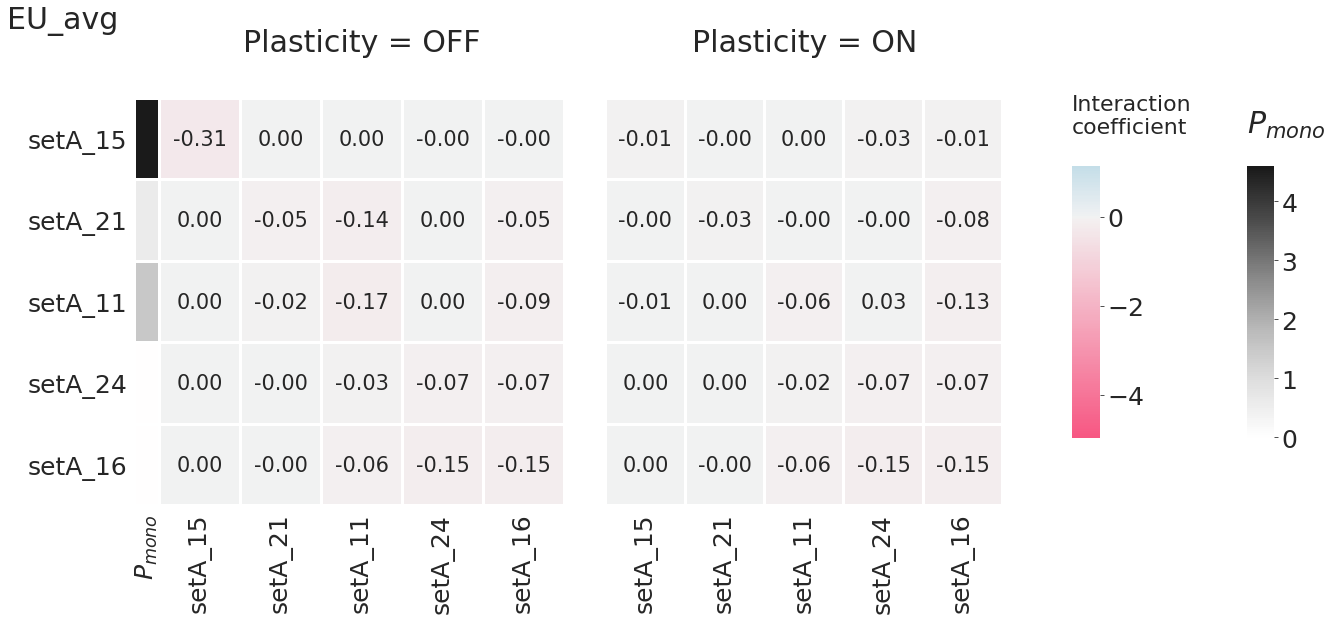

In [10]:
# EU_avg
i=0

fig = plt.figure(figsize=(22, 7.5))
fig.suptitle(media[i], x=0.08, y=1.05)

outer = gridspec.GridSpec(nrows=6, ncols=2, figure=fig, wspace=0.12, hspace=0.0, width_ratios=[0.75, 0.25])

inner_heatmap = gridspec.GridSpecFromSubplotSpec(nrows=1, ncols=2, subplot_spec=outer[:, 0], wspace=0.1, hspace=0.0, width_ratios=(0.52, 0.48))
inner_cbar = gridspec.GridSpecFromSubplotSpec(nrows=1, ncols=10, subplot_spec=outer[1:-1, 1], wspace=0.05, hspace=0.0)


sfm_space = gridspec.GridSpecFromSubplotSpec(nrows=1, ncols=2, subplot_spec=inner_heatmap[0], 
                                             wspace=0.0, hspace=0.0, width_ratios=[0.058, 0.942])
species_meta = fig.add_subplot(sfm_space[0])
sfm_hm = fig.add_subplot(sfm_space[1])
sfm_hm.set_title('Plasticity = OFF', y=1.1)

plastic_hm = fig.add_subplot(inner_heatmap[1])
plastic_hm.set_title('Plasticity = ON', y=1.1)

inter_cbar = fig.add_subplot(inner_cbar[0])
inter_cbar.set_title('Interaction\ncoefficient', fontdict={'fontsize':22}, loc='left', y=1.1)

meta_cbar = fig.add_subplot(inner_cbar[6])
meta_cbar.set_title(r'$\it{P}_{mono}$', fontdict={'fontsize':30}, loc='left', y=1.1)

# Interaction coefficients
sns.heatmap(data=sfm_interactions[i, :, :], vmin=pco_min, vmax=pco_max, center=0.0, 
            xticklabels=plastic_meta['species_ID'], yticklabels=False, 
            cmap=interaction_cmap, square=True, linewidths=2.0,
            annot=True, fmt='.2f', annot_kws={'fontsize':'small'},
            cbar=False, ax=sfm_hm)

sns.heatmap(data=plastic_interactions[i, :, :], vmin=pco_min, vmax=pco_max, center=0.0, 
            xticklabels=plastic_meta['species_ID'], yticklabels=False, 
            cmap=interaction_cmap, square=True, linewidths=2.0, 
            annot=True, fmt='.2f', annot_kws={'fontsize':'small'},
            cbar_ax=inter_cbar, ax=plastic_hm)

# Species metadata
species_meta = sns.heatmap(mono_plas[[media[i]]],xticklabels=[r'$\it{P}_{mono}$'], yticklabels=True, 
                           cmap=plasticity_cmap, center=0.0, vmin=pmo_min, vmax=pmo_max, linewidths=2.0, 
                           cbar_ax=meta_cbar, ax=species_meta)
species_meta.set_ylabel('')    
species_meta.set_xlabel('')
species_meta.set_xticklabels(species_meta.get_xticklabels(), rotation = 90)

species_meta.axis('tight')
sfm_hm.axis('tight')
plastic_hm.axis('tight')

inter_cbar.axis('tight')
meta_cbar.axis('tight')

(-0.009463740740957792,
 4.593989384194082,
 -0.009463740740957792,
 4.593989384194082)

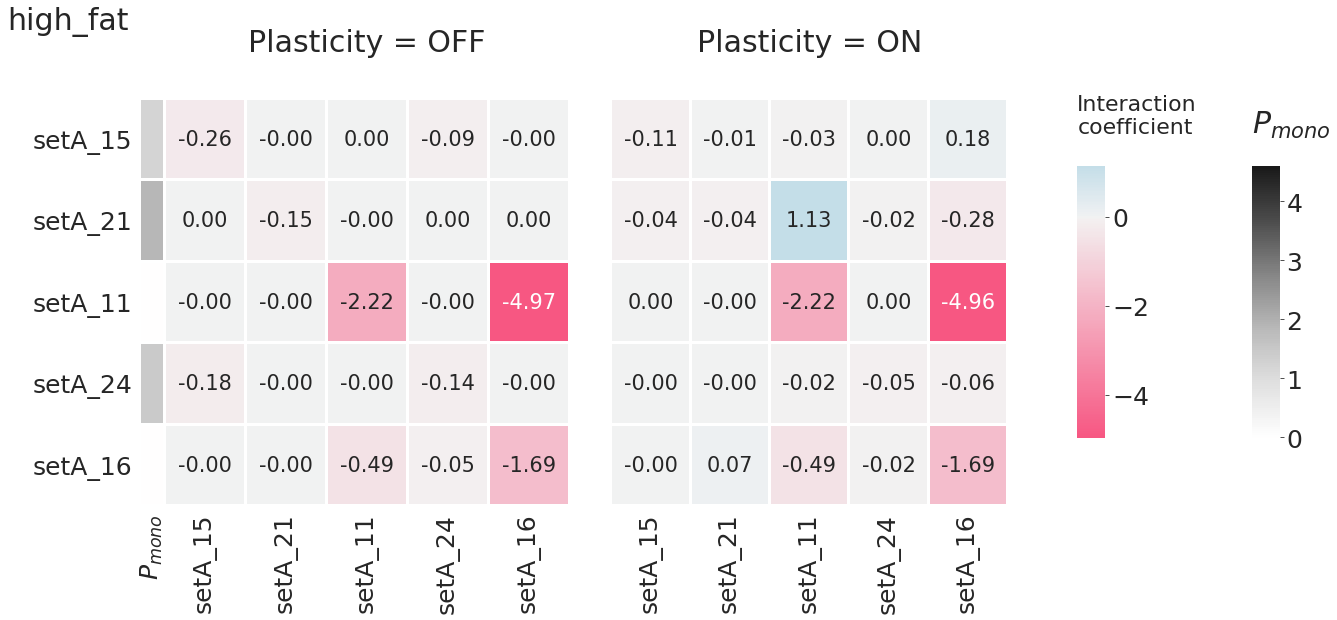

In [11]:
# high_fat
i=1

fig = plt.figure(figsize=(22, 7.5))
fig.suptitle(media[i], x=0.08, y=1.05)

outer = gridspec.GridSpec(nrows=6, ncols=2, figure=fig, wspace=0.12, hspace=0.0, width_ratios=[0.75, 0.25])

inner_heatmap = gridspec.GridSpecFromSubplotSpec(nrows=1, ncols=2, subplot_spec=outer[:, 0], wspace=0.1, hspace=0.0, width_ratios=(0.52, 0.48))
inner_cbar = gridspec.GridSpecFromSubplotSpec(nrows=1, ncols=10, subplot_spec=outer[1:-1, 1], wspace=0.05, hspace=0.0)


sfm_space = gridspec.GridSpecFromSubplotSpec(nrows=1, ncols=2, subplot_spec=inner_heatmap[0], 
                                             wspace=0.0, hspace=0.0, width_ratios=[0.058, 0.942])
species_meta = fig.add_subplot(sfm_space[0])
sfm_hm = fig.add_subplot(sfm_space[1])
sfm_hm.set_title('Plasticity = OFF', y=1.1)

plastic_hm = fig.add_subplot(inner_heatmap[1])
plastic_hm.set_title('Plasticity = ON', y=1.1)

inter_cbar = fig.add_subplot(inner_cbar[0])
inter_cbar.set_title('Interaction\ncoefficient', fontdict={'fontsize':22}, loc='left', y=1.1)

meta_cbar = fig.add_subplot(inner_cbar[6])
meta_cbar.set_title(r'$\it{P}_{mono}$', fontdict={'fontsize':30}, loc='left', y=1.1)

# Interaction coefficients
sns.heatmap(data=sfm_interactions[i, :, :], vmin=pco_min, vmax=pco_max, center=0.0, 
            xticklabels=plastic_meta['species_ID'], yticklabels=False, 
            cmap=interaction_cmap, square=True, linewidths=2.0,
            annot=True, fmt='.2f', annot_kws={'fontsize':'small'},
            cbar=False, ax=sfm_hm)

sns.heatmap(data=plastic_interactions[i, :, :], vmin=pco_min, vmax=pco_max, center=0.0, 
            xticklabels=plastic_meta['species_ID'], yticklabels=False, 
            cmap=interaction_cmap, square=True, linewidths=2.0, 
            annot=True, fmt='.2f', annot_kws={'fontsize':'small'},
            cbar_ax=inter_cbar, ax=plastic_hm)

# Species metadata
species_meta = sns.heatmap(mono_plas[[media[i]]],xticklabels=[r'$\it{P}_{mono}$'], yticklabels=True, 
                           cmap=plasticity_cmap, center=0.0, vmin=pmo_min, vmax=pmo_max, linewidths=2.0, 
                           cbar_ax=meta_cbar, ax=species_meta)
species_meta.set_ylabel('')    
species_meta.set_xlabel('')
species_meta.set_xticklabels(species_meta.get_xticklabels(), rotation = 90)

species_meta.axis('tight')
sfm_hm.axis('tight')
plastic_hm.axis('tight')

inter_cbar.axis('tight')
meta_cbar.axis('tight')

In [12]:
plastic_interactions, plastic_meta = compute.interaction_coeffs(data_dir, mono_data_dir, culture_type, media, plastic=True, 
                                                                rm_compet_excl=False, 
                                                                intra=False, method='glv')
sfm_interactions, sfm_meta = compute.interaction_coeffs(data_dir, mono_data_dir, culture_type, media, plastic=False, 
                                                        rm_compet_excl=False,
                                                        intra=False, method='glv')

pco_min = min(np.nanmin(sfm_interactions), np.nanmin(plastic_interactions))
print(pco_min)
pco_max = max(np.nanmax(sfm_interactions), np.nanmax(plastic_interactions))
print(pco_max)

-4.966837399985668
1.1320531783128378


(-0.009463740740957792,
 4.593989384194082,
 -0.009463740740957792,
 4.593989384194082)

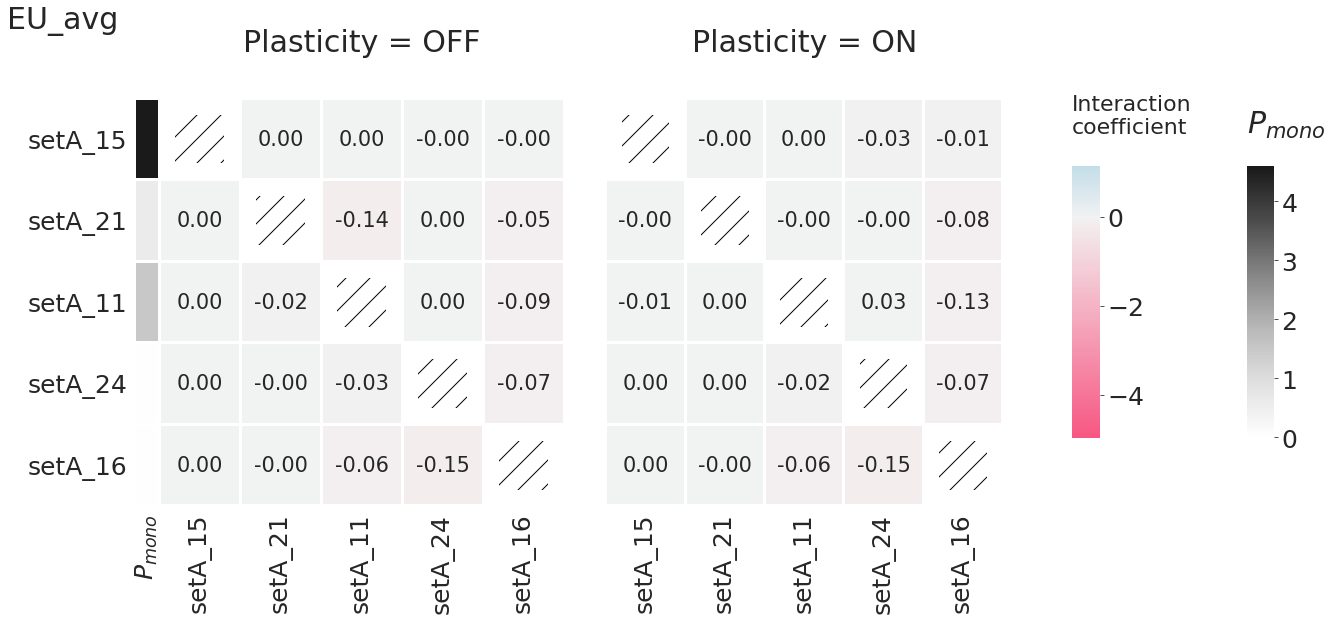

In [13]:
# EU_avg
i=0

fig = plt.figure(figsize=(22, 7.5))
fig.suptitle(media[i], x=0.08, y=1.05)

outer = gridspec.GridSpec(nrows=6, ncols=2, figure=fig, wspace=0.12, hspace=0.0, width_ratios=[0.75, 0.25])

inner_heatmap = gridspec.GridSpecFromSubplotSpec(nrows=1, ncols=2, subplot_spec=outer[:, 0], wspace=0.1, hspace=0.0, width_ratios=(0.52, 0.48))
inner_cbar = gridspec.GridSpecFromSubplotSpec(nrows=1, ncols=10, subplot_spec=outer[1:-1, 1], wspace=0.05, hspace=0.0)


sfm_space = gridspec.GridSpecFromSubplotSpec(nrows=1, ncols=2, subplot_spec=inner_heatmap[0], 
                                             wspace=0.0, hspace=0.0, width_ratios=[0.058, 0.942])
species_meta = fig.add_subplot(sfm_space[0])
sfm_hm = fig.add_subplot(sfm_space[1])
sfm_hm.set_title('Plasticity = OFF', y=1.1)

plastic_hm = fig.add_subplot(inner_heatmap[1])
plastic_hm.set_title('Plasticity = ON', y=1.1)

inter_cbar = fig.add_subplot(inner_cbar[0])
inter_cbar.set_title('Interaction\ncoefficient', fontdict={'fontsize':22}, loc='left', y=1.1)

meta_cbar = fig.add_subplot(inner_cbar[6])
meta_cbar.set_title(r'$\it{P}_{mono}$', fontdict={'fontsize':30}, loc='left', y=1.1)

# Interaction coefficients
sns.heatmap(data=sfm_interactions[i, :, :], vmin=pco_min, vmax=pco_max, center=0.0, 
            xticklabels=plastic_meta['species_ID'], yticklabels=False, 
            cmap=interaction_cmap, square=True, linewidths=2.0,
            annot=True, fmt='.2f', annot_kws={'fontsize':'small'},
            cbar=False, ax=sfm_hm)

sns.heatmap(data=plastic_interactions[i, :, :], vmin=pco_min, vmax=pco_max, center=0.0, 
            xticklabels=plastic_meta['species_ID'], yticklabels=False, 
            cmap=interaction_cmap, square=True, linewidths=2.0, 
            annot=True, fmt='.2f', annot_kws={'fontsize':'small'},
            cbar_ax=inter_cbar, ax=plastic_hm)

# Annotate region of intra-species interaction 
sfm_patch = [(a+0.2, a+0.2) for a in range(sfm_interactions.shape[1])]
for p in sfm_patch:
    sfm_hm.add_patch(Rectangle(p, 0.6, 0.6, hatch='/', edgecolor='black', fill=False, lw=0))

plastic_patch = [(a+0.2, a+0.2) for a in range(plastic_interactions.shape[1])]
for p in plastic_patch:
    plastic_hm.add_patch(Rectangle(p, 0.6, 0.6, hatch='/', edgecolor='black', fill=False, lw=0))

# Species metadata
species_meta = sns.heatmap(mono_plas[[media[i]]],xticklabels=[r'$\it{P}_{mono}$'], yticklabels=True, 
                           cmap=plasticity_cmap, center=0.0, vmin=pmo_min, vmax=pmo_max, linewidths=2.0, 
                           cbar_ax=meta_cbar, ax=species_meta)
species_meta.set_ylabel('')    
species_meta.set_xlabel('')
species_meta.set_xticklabels(species_meta.get_xticklabels(), rotation = 90)

species_meta.axis('tight')
sfm_hm.axis('tight')
plastic_hm.axis('tight')

inter_cbar.axis('tight')
meta_cbar.axis('tight')

(-0.009463740740957792,
 4.593989384194082,
 -0.009463740740957792,
 4.593989384194082)

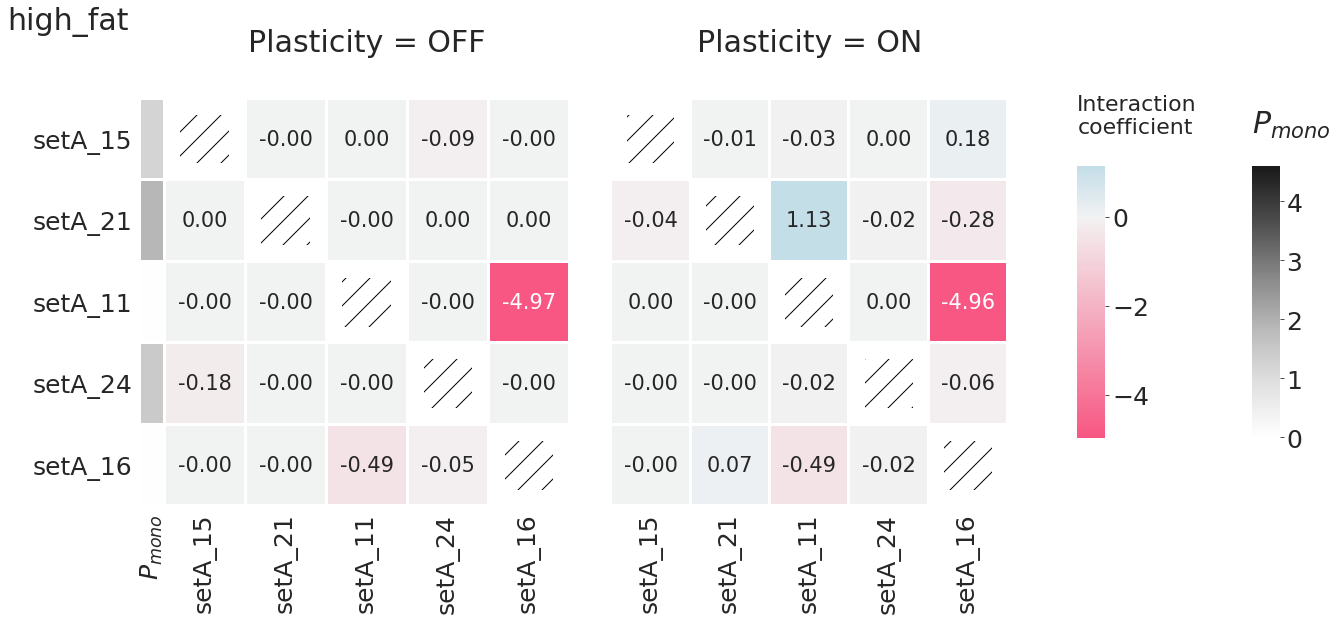

In [14]:
# high_fat
i=1

fig = plt.figure(figsize=(22, 7.5))
fig.suptitle(media[i], x=0.08, y=1.05)

outer = gridspec.GridSpec(nrows=6, ncols=2, figure=fig, wspace=0.12, hspace=0.0, width_ratios=[0.75, 0.25])

inner_heatmap = gridspec.GridSpecFromSubplotSpec(nrows=1, ncols=2, subplot_spec=outer[:, 0], wspace=0.1, hspace=0.0, width_ratios=(0.52, 0.48))
inner_cbar = gridspec.GridSpecFromSubplotSpec(nrows=1, ncols=10, subplot_spec=outer[1:-1, 1], wspace=0.05, hspace=0.0)


sfm_space = gridspec.GridSpecFromSubplotSpec(nrows=1, ncols=2, subplot_spec=inner_heatmap[0], 
                                             wspace=0.0, hspace=0.0, width_ratios=[0.058, 0.942])
species_meta = fig.add_subplot(sfm_space[0])
sfm_hm = fig.add_subplot(sfm_space[1])
sfm_hm.set_title('Plasticity = OFF', y=1.1)

plastic_hm = fig.add_subplot(inner_heatmap[1])
plastic_hm.set_title('Plasticity = ON', y=1.1)

inter_cbar = fig.add_subplot(inner_cbar[0])
inter_cbar.set_title('Interaction\ncoefficient', fontdict={'fontsize':22}, loc='left', y=1.1)

meta_cbar = fig.add_subplot(inner_cbar[6])
meta_cbar.set_title(r'$\it{P}_{mono}$', fontdict={'fontsize':30}, loc='left', y=1.1)

# Interaction coefficients
sns.heatmap(data=sfm_interactions[i, :, :], vmin=pco_min, vmax=pco_max, center=0.0, 
            xticklabels=plastic_meta['species_ID'], yticklabels=False, 
            cmap=interaction_cmap, square=True, linewidths=2.0,
            annot=True, fmt='.2f', annot_kws={'fontsize':'small'},
            cbar=False, ax=sfm_hm)

sns.heatmap(data=plastic_interactions[i, :, :], vmin=pco_min, vmax=pco_max, center=0.0, 
            xticklabels=plastic_meta['species_ID'], yticklabels=False, 
            cmap=interaction_cmap, square=True, linewidths=2.0, 
            annot=True, fmt='.2f', annot_kws={'fontsize':'small'},
            cbar_ax=inter_cbar, ax=plastic_hm)

# Annotate region of intra-species interaction 
sfm_patch = [(a+0.2, a+0.2) for a in range(sfm_interactions.shape[1])]
for p in sfm_patch:
    sfm_hm.add_patch(Rectangle(p, 0.6, 0.6, hatch='/', edgecolor='black', fill=False, lw=0))

plastic_patch = [(a+0.2, a+0.2) for a in range(plastic_interactions.shape[1])]
for p in plastic_patch:
    plastic_hm.add_patch(Rectangle(p, 0.6, 0.6, hatch='/', edgecolor='black', fill=False, lw=0))

# Species metadata
species_meta = sns.heatmap(mono_plas[[media[i]]],xticklabels=[r'$\it{P}_{mono}$'], yticklabels=True, 
                           cmap=plasticity_cmap, center=0.0, vmin=pmo_min, vmax=pmo_max, linewidths=2.0, 
                           cbar_ax=meta_cbar, ax=species_meta)
species_meta.set_ylabel('')    
species_meta.set_xlabel('')
species_meta.set_xticklabels(species_meta.get_xticklabels(), rotation = 90)

species_meta.axis('tight')
sfm_hm.axis('tight')
plastic_hm.axis('tight')

inter_cbar.axis('tight')
meta_cbar.axis('tight')